In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, as_completed
import dask.dataframe as dd
import dask.bag as db
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Configure the SLURM cluster
cluster = SLURMCluster(queue='caslake', cores=20, memory='80GB', 
                       processes=20, walltime='04:00:00', interface='ib0',
                       job_extra=['--account=macs30123'])

# Request resources
cluster.scale(jobs=1)

/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36321 instead
  warnings.warn(


In [2]:
# create Dask client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.25.0.66:36321/status,
Dashboard: http://172.25.0.66:36321/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.25.0.66:38613,Workers: 0
Dashboard: http://172.25.0.66:36321/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
# define file path
citing_df_folder = 'citing_df.parquet'
vertices_df_folder = 'vertices.parquet'
edges_df_folder = 'edges.parquet'
cluster_info_path = '../NLP_clustering/df_with_clusters_merged.xlsx'

# read data
citing_ddf = dd.read_parquet(citing_df_folder)
vertices_ddf = dd.read_parquet(vertices_df_folder)
edges_ddf = dd.read_parquet(edges_df_folder)
clusters_df = pd.read_excel(cluster_info_path)

# from Dask DataFrame to Pandas DataFrame
citing_df = citing_ddf.compute()
vertices_df = vertices_ddf.compute()
edges_df = edges_ddf.compute()

In [4]:
# create NetworkX graph
def create_graph(vertices_df, edges_df):
    G = nx.DiGraph()
    vertices = vertices_df['id'].tolist()
    edges = citing_df[['citing_id', 'cited_id']].values.tolist()
    
    G.add_nodes_from(vertices)
    G.add_edges_from(edges)
    return G

G = create_graph(vertices_df, citing_df)

# get nodes randomly
def get_subgraph(graph, num_nodes):
    sampled_nodes = random.sample(list(graph.nodes()), num_nodes)
    return graph.subgraph(sampled_nodes)

In [5]:
# # for test only
# num_nodes_to_select = 1000  

# # sub graph test
# subgraph = get_subgraph(G, num_nodes_to_select)
subgraph = G
# use Dask to calculate measures
def compute_network_measures(graph):
    network_density = nx.density(graph)
    degree_centrality_dict = nx.degree_centrality(graph)
    avg_degree = sum(dict(graph.degree()).values()) / graph.number_of_nodes()
    pagerank_dict = nx.pagerank(graph)
    betweenness_dict = nx.betweenness_centrality(graph)
    closeness_dict = nx.closeness_centrality(graph)
    return network_density, degree_centrality_dict, avg_degree, pagerank_dict, betweenness_dict, closeness_dict

# split graph
num_partitions = 19
subgraph_nodes = list(subgraph.nodes())
node_chunks = [subgraph_nodes[i::num_partitions] for i in range(num_partitions)]
print("finish prep")
# calculation
futures = [client.submit(compute_network_measures, subgraph.subgraph(chunk)) for chunk in node_chunks]
print("finish calculation")
# collect results
network_density = 0
degree_centrality_dict, avg_degree_dict, pagerank_dict, betweenness_dict, closeness_dict = {}, {}, {}, {}, {}
for future in as_completed(futures):
    net_density, deg_cen, avg_deg, pagerank, betw, close = future.result()
    network_density += net_density
    degree_centrality_dict.update(deg_cen)
    avg_degree_dict.update({k: avg_deg for k in deg_cen.keys()})
    pagerank_dict.update(pagerank)
    betweenness_dict.update(betw)
    closeness_dict.update(close)
print("finish collecting")
# Calculate the overall network density
network_density = network_density / num_partitions

# Add metrics to node attributes
nx.set_node_attributes(subgraph, degree_centrality_dict, 'degree_centrality')
nx.set_node_attributes(subgraph, pagerank_dict, 'pagerank')
nx.set_node_attributes(subgraph, betweenness_dict, 'betweenness')
nx.set_node_attributes(subgraph, closeness_dict, 'closeness')
print("finish adding")

# Create a DataFrame to save node metrics and cluster information
nodes_data = []
for node in subgraph.nodes(data=True):
    node_id = node[0]
    degree_centrality = node[1].get('degree_centrality')
    pagerank = node[1].get('pagerank')
    betweenness = node[1].get('betweenness')
    closeness = node[1].get('closeness')
    nodes_data.append([node_id, degree_centrality, pagerank, betweenness, closeness])

nodes_df = pd.DataFrame(nodes_data, columns=['node', 'degree_centrality', 'pagerank', 'betweenness', 'closeness'])

# Merge cluster information
nodes_df = nodes_df.merge(clusters_df[['id', 'keywords_cluster']], left_on='node', right_on='id', how='left')

finish prep


/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/site-packages/distributed/worker.py:2845: UserWarning: Large object of size 31.16 MiB detected in task graph: 
  (<networkx.classes.digraph.DiGraph object at 0x7efbbc012580>,)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


finish calculation
finish collecting
finish adding


In [6]:
# check DataFrame
print(nodes_df.head())

               node  degree_centrality  pagerank  betweenness  closeness  \
0  US-2022351156-A1           0.000000  0.000034          0.0   0.000000   
1    US-11540111-B2           0.000000  0.000034          0.0   0.000000   
2  US-2021104145-A1           0.000035  0.000063          0.0   0.000035   
3  US-2023039855-A1           0.000000  0.000034          0.0   0.000000   
4    US-11487266-B2           0.000000  0.000034          0.0   0.000000   

                 id  keywords_cluster  
0  US-2022351156-A1               4.0  
1    US-11540111-B2               8.0  
2  US-2021104145-A1               0.0  
3  US-2023039855-A1               0.0  
4    US-11487266-B2               8.0  


In [9]:
nodes_df.to_csv("result.csv", index=False)

In [7]:
# Convert Pandas DataFrame to Dask DataFrame
nodes_ddf = dd.from_pandas(nodes_df, npartitions=4)

# Calculate the average metrics for each cluster
cluster_stats_ddf = nodes_ddf.groupby('keywords_cluster').mean().compute()

# Convert the result back to Pandas DataFrame for plotting
cluster_stats = cluster_stats_ddf.reset_index()

# Print to check the contents of cluster_stats
print(cluster_stats)


    keywords_cluster  degree_centrality  pagerank   betweenness  closeness
0                0.0           0.000003  0.000036  3.755548e-12   0.000002
1                1.0           0.000002  0.000035  1.014519e-12   0.000002
2                2.0           0.000003  0.000036  2.261524e-12   0.000002
3                3.0           0.000002  0.000035  3.281329e-13   0.000001
4                4.0           0.000003  0.000036  2.632757e-12   0.000003
5                5.0           0.000003  0.000036  7.621510e-13   0.000003
6                6.0           0.000003  0.000036  4.087106e-12   0.000002
7                7.0           0.000004  0.000036  3.874674e-11   0.000003
8                8.0           0.000004  0.000036  9.244777e-12   0.000003
9                9.0           0.000002  0.000035  6.869202e-13   0.000001
10              10.0           0.000003  0.000036  0.000000e+00   0.000003
11              11.0           0.000003  0.000035  1.449342e-12   0.000002


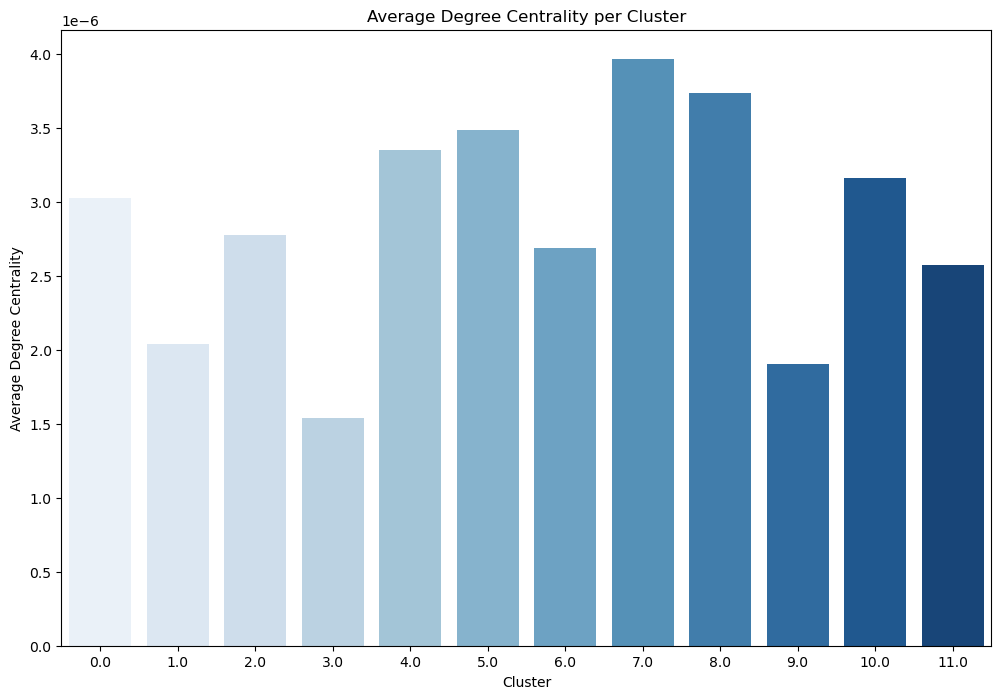

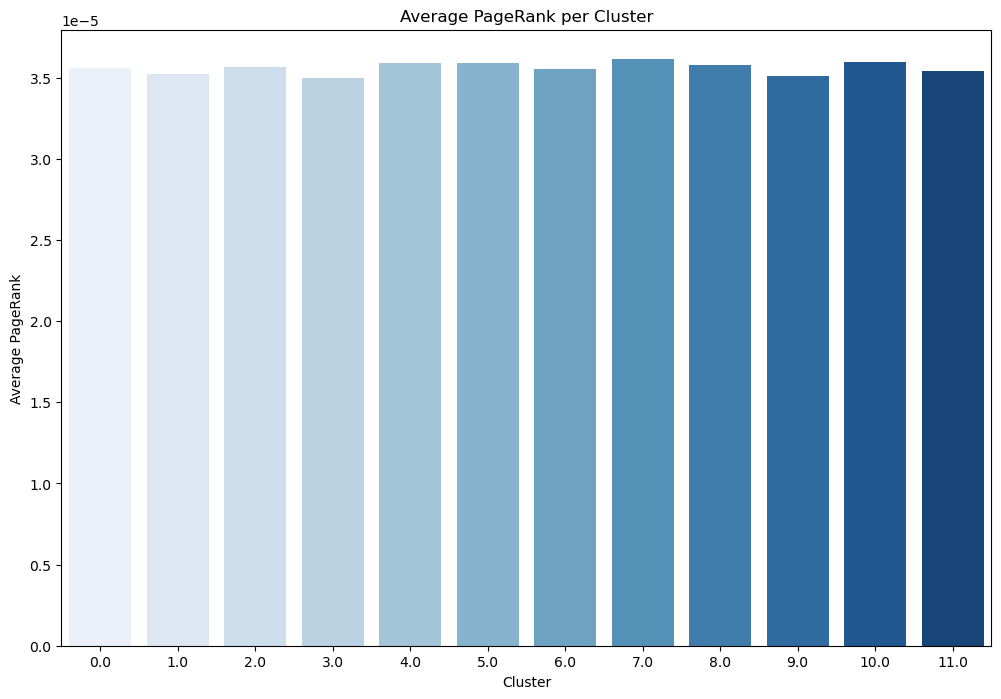

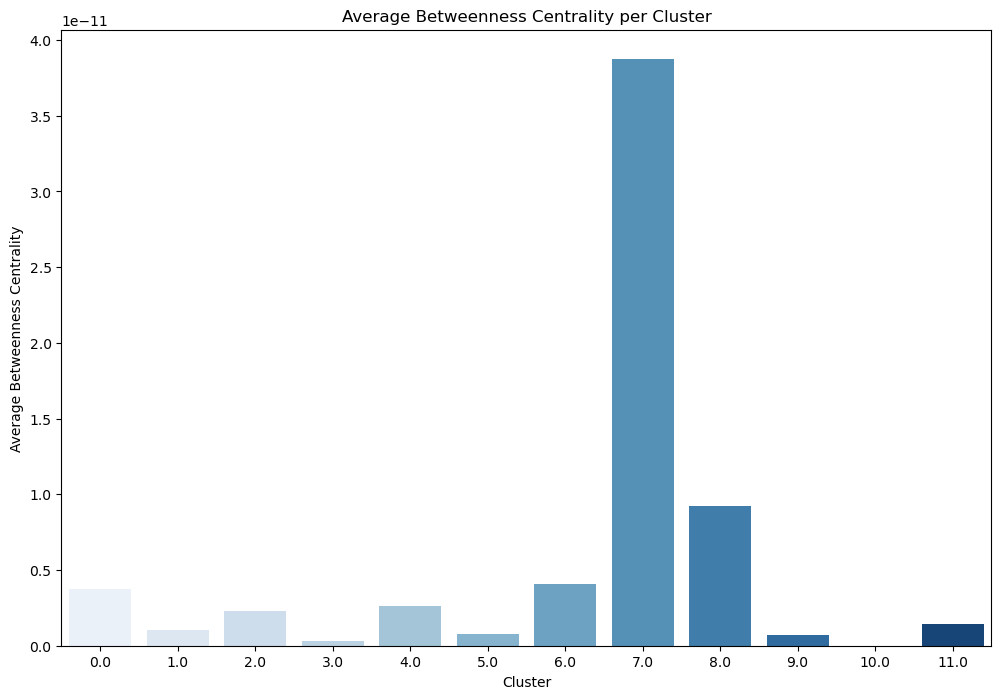

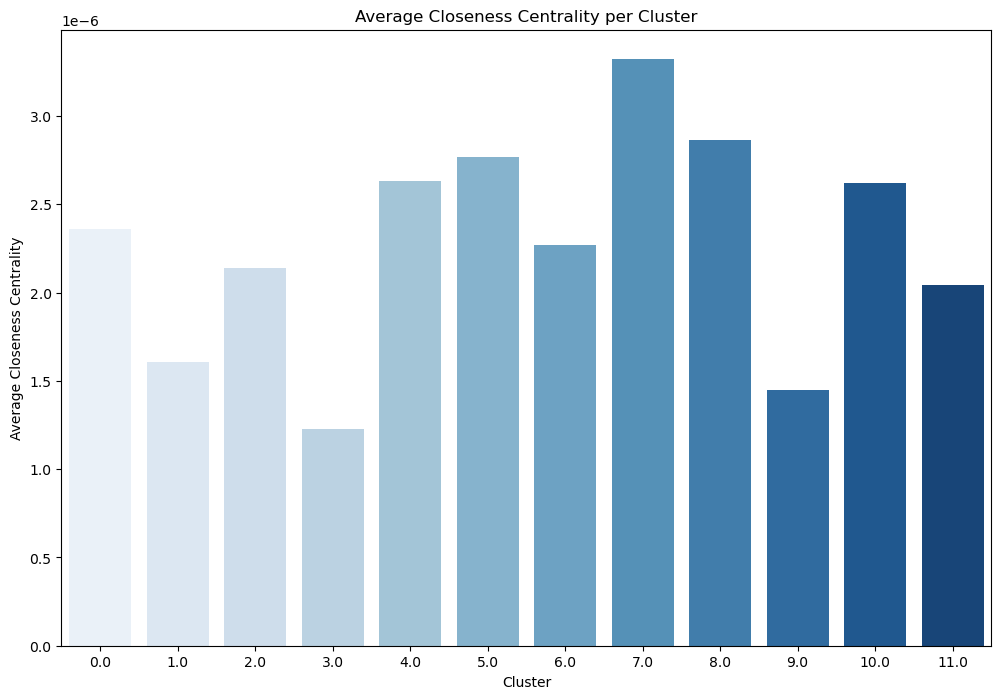

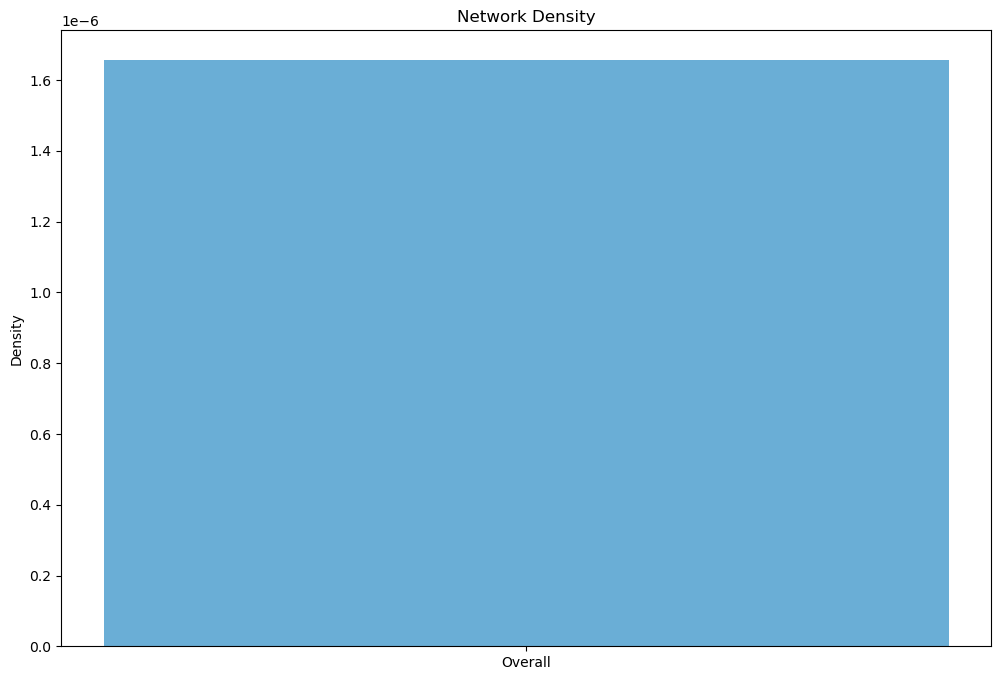

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("Blues", n_colors=len(cluster_stats))

plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_stats, x='keywords_cluster', y='degree_centrality', palette=palette)
plt.title('Average Degree Centrality per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Degree Centrality')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_stats, x='keywords_cluster', y='pagerank', palette=palette)
plt.title('Average PageRank per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average PageRank')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_stats, x='keywords_cluster', y='betweenness', palette=palette)
plt.title('Average Betweenness Centrality per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Betweenness Centrality')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_stats, x='keywords_cluster', y='closeness', palette=palette)
plt.title('Average Closeness Centrality per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Closeness Centrality')
plt.show()

plt.figure(figsize=(12, 8))
plt.bar(['Overall'], [network_density], color=sns.color_palette("Blues", 1))
plt.title('Network Density')
plt.ylabel('Density')
plt.show()


In [18]:
client.close()